In [1]:
import keras_tuner as kt
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import shap
from tensorflow.keras import regularizers


In [2]:
####################################################### load dataframe
# Load dataset from ppi.csv
df = pd.read_csv("ppi.csv")

print(df.columns)

Index(['Unnamed: 0', 'domain', 'aa_ProtPosition', 'uniprot_id', 'Rlength',
       'sequence', 'normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc',
       ...
       '9_wm_pssm_K', '9_wm_pssm_M', '9_wm_pssm_F', '9_wm_pssm_P',
       '9_wm_pssm_S', '9_wm_pssm_T', '9_wm_pssm_W', '9_wm_pssm_Y',
       '9_wm_pssm_V', 'p_interface'],
      dtype='object', length=138)


In [3]:
####################################################### fix sequence in DF
# Define the set of standard amino acids
standard_aas = set("ACDEFGHIKLMNPQRSTVWY")

# detect non-standard amino acids in a sequence (here, each sequence is a single letter)
def has_non_standard(seq):
    return seq not in standard_aas

# identify rows where sequence contains a non-standard amino acid
non_standard_mask = df["sequence"].apply(has_non_standard)

if non_standard_mask.any():
    print("Found non-standard amino acids in the following rows:")
    print(df.loc[non_standard_mask, ["uniprot_id", "sequence"]])
    # Remove rows with non-standard amino acids
    df = df.loc[~non_standard_mask].copy()
else:
    print("All sequences contain standard amino acids.")
    

seq_dummies = pd.get_dummies(df["sequence"], prefix="aa")

# Ensure that we have columns for all 20 standard amino acids (in case some letters are missing in the data)
aa_order = "ACDEFGHIKLMNPQRSTVWY"
expected_cols = [f"aa_{aa}" for aa in aa_order]
seq_dummies = seq_dummies.reindex(columns=expected_cols, fill_value=0)

# Drop the original sequence column and concatenate the one-hot encoded columns
df = df.drop(columns=["sequence"])
df = pd.concat([df, seq_dummies], axis=1)



Found non-standard amino acids in the following rows:
      uniprot_id sequence
29636     Q01786        X



Class Distribution:
p_interface
0    57304
1     7845
Name: count, dtype: int64


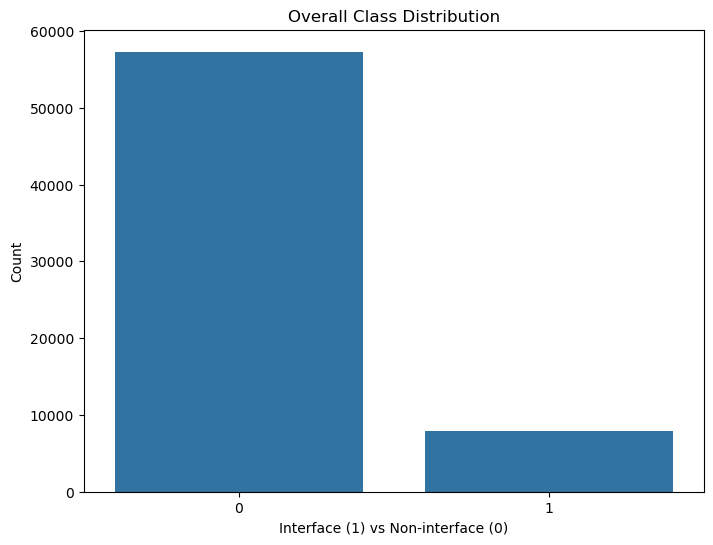

In [4]:
######################################################## check overall class distrubution
# Check overall class distribution for the target
target = "p_interface"
class_counts = df[target].value_counts()
print("\nClass Distribution:")
print(class_counts)

# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=df)
plt.title("Overall Class Distribution")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()

In [5]:
########################################################## make train, validation and test split
# Count the number of unique proteins based on uniprot_id
unique_proteins = df['uniprot_id'].nunique()
print("\nNumber of Unique Proteins (uniprot_id):", unique_proteins)

# Explore the class distribution per protein
protein_class_distribution = df.groupby('uniprot_id')[target].value_counts().unstack().fillna(0)
print("\nProtein-wise Class Distribution (first 5 proteins):")
print(protein_class_distribution.head())

# Define target and keep uniprot_id for splitting (we'll drop it later)
target = "p_interface"

# Get unique uniprot_ids to use as groups
unique_groups = df['uniprot_id'].unique()

# First split: 90% train and 10% temporary (which will be split into validation and test)
train_groups, temp_groups= train_test_split(unique_groups, test_size=0.4, random_state=22)

# Second split: Split the temporary groups into validation and test equally (15% each)
val_groups, test_groups = train_test_split(temp_groups, test_size=0.6, random_state=22)

# Create the train, validation, and test dataframes by filtering on uniprot_id groups
train_df = df[df['uniprot_id'].isin(train_groups)]
val_df   = df[df['uniprot_id'].isin(val_groups)]
test_df  = df[df['uniprot_id'].isin(test_groups)]

########
train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
val_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
test_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])

# Define features and target for each split.
# Drop the columns "uniprot_id", "domain", etc.
X_train = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train = train_df[target]

X_val = val_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_val = val_df[target]

X_test = test_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_test = test_df[target]


Number of Unique Proteins (uniprot_id): 228

Protein-wise Class Distribution (first 5 proteins):
p_interface    0   1
uniprot_id          
A0A010       185  75
A0A024RAV5   175  13
A0A0D5YE19   290  26
A0A0F4FI39   324  10
A0A0H2VDD2   199   8


In [6]:
####################################### calcualte class weight of train on the validation
class_weights = compute_class_weight("balanced", classes=np.unique(y_val), y=y_val)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_val), class_weights)}
print(class_weights)

{0: 0.5584723080090591, 1: 4.775528169014085}


In [7]:
######################################### check overlap

# Check that the splits have disjoint uniprot_ids
train_ids = set(train_df['uniprot_id'])
val_ids   = set(val_df['uniprot_id'])
test_ids  = set(test_df['uniprot_id'])

print("Overlap between Train & Validation:", train_ids.intersection(val_ids))
print("Overlap between Train & Test:", train_ids.intersection(test_ids))
print("Overlap between Validation & Test:", val_ids.intersection(test_ids))

print("Unique uniprot_ids in Train:", train_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Validation:", val_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Test:", test_df["uniprot_id"].nunique())

Overlap between Train & Validation: set()
Overlap between Train & Test: set()
Overlap between Validation & Test: set()
Unique uniprot_ids in Train: 136
Unique uniprot_ids in Validation: 36
Unique uniprot_ids in Test: 56


In [8]:
######################################### undersampeling
"""
# Initialize the RandomUnderSampler
rus_50 = RandomUnderSampler(random_state=42)
rus_30 = RandomUnderSampler(random_state=42,sampling_strategy=0.3)

# apply the undersampler on the training data
X_train, y_train = rus_50.fit_resample(X_train, y_train)


# shape of the training data before and after undersampling
print("Undersampled training set shape:", X_train.shape, y_train.shape)
print("Undersampled val set shape:", X_val.shape, y_val.shape)
print("Undersampled test set shape:", X_test.shape, y_test.shape)

"""

'\n# Initialize the RandomUnderSampler\nrus_50 = RandomUnderSampler(random_state=42)\nrus_30 = RandomUnderSampler(random_state=42,sampling_strategy=0.3)\n\n# apply the undersampler on the training data\nX_train, y_train = rus_50.fit_resample(X_train, y_train)\n\n\n# shape of the training data before and after undersampling\nprint("Undersampled training set shape:", X_train.shape, y_train.shape)\nprint("Undersampled val set shape:", X_val.shape, y_val.shape)\nprint("Undersampled test set shape:", X_test.shape, y_test.shape)\n\n'

In [9]:
###################################################### oversampeling using SMOTE
smote = SMOTE(random_state=42, sampling_strategy='minority')

X_train, y_train = smote.fit_resample(X_train, y_train)

# Print shapes to confirm
print("Oversampled training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Oversampled training set shape: (67922, 151) (67922,)
Validation set shape: (10850, 151) (10850,)
Test set shape: (15545, 151) (15545,)


<Figure size 800x500 with 0 Axes>

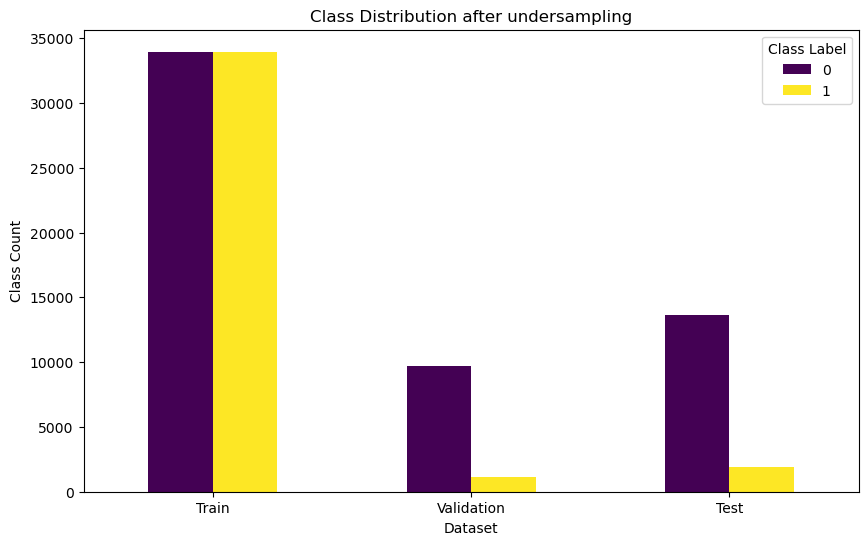

In [10]:
# Count occurrences of each class in train, val, and test sets
train_counts = y_train.value_counts().sort_index()
val_counts = y_val.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

# Create a DataFrame for visualization
class_distribution = pd.DataFrame({
    "Train": train_counts,
    "Validation": val_counts,
    "Test": test_counts
}).T  # Transpose for better plotting

# Plot the class distribution
plt.figure(figsize=(8, 5))
class_distribution.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.xlabel("Dataset")
plt.ylabel("Class Count")
plt.title("Class Distribution after undersampling")
plt.xticks(rotation=0)
plt.legend(title="Class Label")
plt.show()


In [11]:
################################################## scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

In [12]:
#################################################### Linear regression

# Initialize and fit the Linear Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

#y_pred_LR = model.predict(X_test)
y_pred_LR = model.predict_proba(X_test)[:, 1]

# Convert continuous predictions to binary class labels using a threshold of 0.5
y_pred_class_LR = (y_pred_LR >= 0.5).astype(int)

# Evaluate the classifier
accuracy_LR = accuracy_score(y_test, y_pred_class_LR)
precision_LR = precision_score(y_test, y_pred_class_LR, zero_division=0)
recall_LR = recall_score(y_test, y_pred_class_LR, zero_division=0)
f1_LR = f1_score(y_test, y_pred_class_LR, zero_division=0)


C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.51
Precision: 0.17
Recall: 0.79
F1 Score: 0.28
              precision    recall  f1-score   support

           0       0.94      0.47      0.62     13629
           1       0.17      0.79      0.28      1916

    accuracy                           0.51     15545
   macro avg       0.56      0.63      0.45     15545
weighted avg       0.85      0.51      0.58     15545



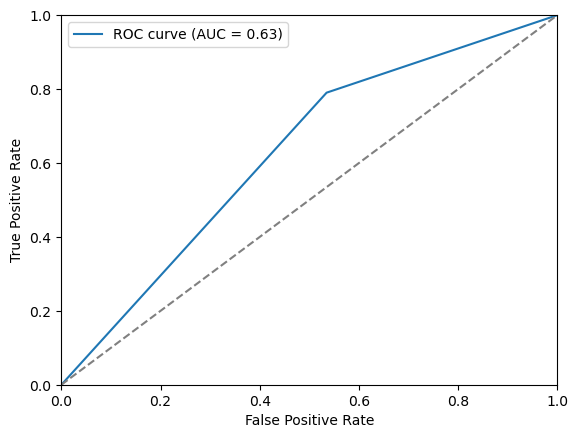

In [13]:
################################################## print results Linear regression

print(f"Accuracy: {accuracy_LR:.2f}")
print(f"Precision: {precision_LR:.2f}")
print(f"Recall: {recall_LR:.2f}")
print(f"F1 Score: {f1_LR:.2f}")

# Compute ROC curve with continuous probabilities
print(classification_report(y_test, y_pred_class_LR, zero_division=0))
fpr_LR, tpr_LR, thresholds = roc_curve(y_test, y_pred_class_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

plt.plot(fpr_LR, tpr_LR, label=f"ROC curve (AUC = {roc_auc_LR:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [14]:
###################################################### hyperparamtater tuning Random Foretst
param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

###################################################### set the class weights here

grid_RF = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight=class_weights), 
    param_grid_RF,
    scoring='accuracy',
    n_jobs=-1
)
grid_RF.fit(X_val, y_val)

print("----- Random Forest Hyperparameter Tuning -----")
print("Best Parameters (RF):", grid_RF.best_params_)
print("Best Validation Accuracy (RF):", grid_RF.best_score_)
best_rf = grid_RF.best_estimator_


----- Random Forest Hyperparameter Tuning -----
Best Parameters (RF): {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Best Validation Accuracy (RF): 0.8578801843317972


In [15]:
################################################# get best scores hyperparamter 
y_pred_RF = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_RF = (y_pred_RF >= 0.5).astype(int)

# Evaluate
accuracy_RF  = accuracy_score(y_test, y_pred_class_RF)
precision_RF = precision_score(y_test, y_pred_class_RF, zero_division=0)
recall_RF    = recall_score(y_test, y_pred_class_RF, zero_division=0)
f1_RF        = f1_score(y_test, y_pred_class_RF, zero_division=0)

Accuracy: 0.88
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     13629
           1       0.00      0.00      0.00      1916

    accuracy                           0.88     15545
   macro avg       0.44      0.50      0.47     15545
weighted avg       0.77      0.88      0.82     15545



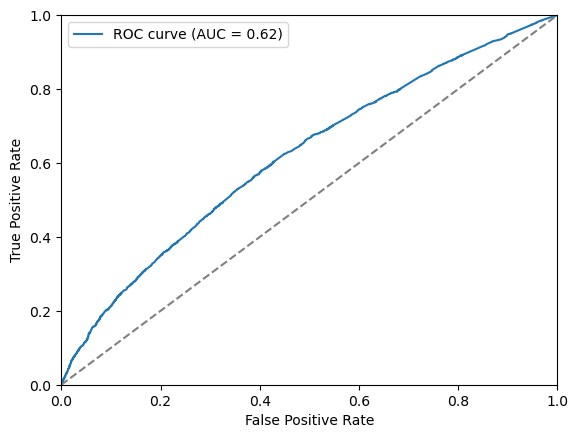

In [16]:
############################################################### print score radndom forest

print(f"Accuracy: {accuracy_RF:.2f}")
print(f"Precision: {precision_RF:.2f}")
print(f"Recall: {recall_RF:.2f}")
print(f"F1 Score: {f1_RF:.2f}")

print(classification_report(y_test, y_pred_class_RF, zero_division=0))

# Use continuous probabilities for the ROC curve
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.plot(fpr_RF, tpr_RF, label=f"ROC curve (AUC = {roc_auc_RF:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [17]:
############################################### hyper paramter tuning XGBoost

param_grid_XGB = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_XGB = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, class_weight=class_weights),
    param_grid_XGB, 
    scoring='accuracy',
    n_jobs=-1
)

# Perform hyperparameter tuning
grid_XGB.fit(X_val, y_val)

# Print best hyperparameters and best validation accuracy
print("----- XGBoost Hyperparameter Tuning -----")
print("Best Parameters (XGB):", grid_XGB.best_params_)
print("Best Validation Accuracy (XGB):", grid_XGB.best_score_)

# Get the best model
best_xgb = grid_XGB.best_estimator_

# Predict on the test set
y_pred_XGB = best_xgb.predict_proba(X_test)[:, 1]


----- XGBoost Hyperparameter Tuning -----
Best Parameters (XGB): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best Validation Accuracy (XGB): 0.895299539170507


C:\Users\youpz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:57:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [18]:
############################################### running XGBoost

# Convert probabilities to binary class predictions using a threshold of 0.5
y_pred_class_XGB = [1 if prob >= 0.5 else 0 for prob in y_pred_XGB]

# Evaluate the classifier
accuracy_XGB = accuracy_score(y_test, y_pred_class_XGB)
precision_XGB = precision_score(y_test, y_pred_class_XGB, zero_division=0)
recall_XGB = recall_score(y_test, y_pred_class_XGB, zero_division=0)
f1_XGB = f1_score(y_test, y_pred_class_XGB, zero_division=0)



XGBoost Classifier Performance:
Accuracy: 0.88
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     13629
           1       0.00      0.00      0.00      1916

    accuracy                           0.88     15545
   macro avg       0.44      0.50      0.47     15545
weighted avg       0.77      0.88      0.82     15545



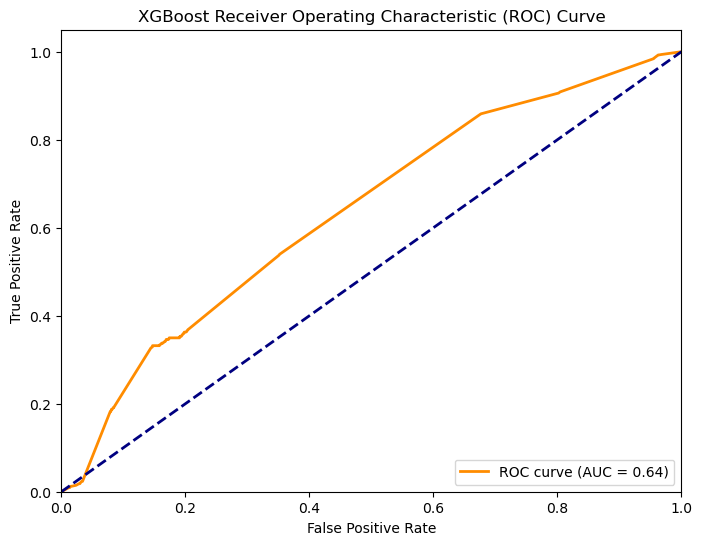

In [19]:
############################################### printing score XGBoost
print("XGBoost Classifier Performance:")
print(f"Accuracy: {accuracy_XGB:.2f}")
print(f"Precision: {precision_XGB:.2f}")
print(f"Recall: {recall_XGB:.2f}")
print(f"F1 Score: {f1_XGB:.2f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_XGB, zero_division=0))

# Compute the ROC curve and ROC-AUC using the predicted probabilities
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test, y_pred_XGB)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGB, tpr_XGB, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_XGB:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [20]:
################################################## make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),  # use dropout to overcome overfitting

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # binairy classification
])

# compile models using adam optimizer, loss = binary_crossentropy (works best for classification) and use accuracy of AUC/
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])



C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
###################################################### train NN

stop_early =  tf.keras.callbacks.EarlyStopping(
    monitor='val_AUC',     
    patience=5,              # number of epochs with no improvement
    restore_best_weights=True, 
    mode='max'
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights,
    callbacks=[stop_early]
)


Epoch 1/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5759 - auc: 0.6611 - loss: 1.1130 - val_accuracy: 0.1745 - val_auc: 0.6555 - val_loss: 1.9650
Epoch 2/50
 130/2123 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5704 - auc: 0.7794 - loss: 0.7453

C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_AUC` which is not available. Available metrics are: accuracy,auc,loss,val_accuracy,val_auc,val_loss
  current = self.get_monitor_value(logs)


2123/2123 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5859 - auc: 0.7779 - loss: 0.7384 - val_accuracy: 0.1921 - val_auc: 0.6496 - val_loss: 1.8977
Epoch 3/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6036 - auc: 0.8070 - loss: 0.6993 - val_accuracy: 0.2097 - val_auc: 0.6177 - val_loss: 1.8532
Epoch 4/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6230 - auc: 0.8222 - loss: 0.6717 - val_accuracy: 0.2181 - val_auc: 0.6220 - val_loss: 1.9468
Epoch 5/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6417 - auc: 0.8388 - loss: 0.6422 - val_accuracy: 0.2314 - val_auc: 0.6300 - val_loss: 1.8226
Epoch 6/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6503 - auc: 0.8451 - loss: 0.6334 - val_accuracy: 0.2457 - val_auc: 0.6282 - val_loss: 1.7804
Epoch 7/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6626 - auc: 0.8537 - loss: 0.6165 - val_accuracy: 0.2769 - val_auc: 0.6170 - val_loss: 1.7675
Epoch 8/50
2123/2123 ━━━━━━━━━━━━━━━━━━

In [22]:
####################################################### caluculate scores neural network
y_pred_probs_NN = model.predict(X_test).flatten()  

#Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)



486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


Accuracy: 0.40
Precision: 0.15
Recall: 0.86
F1 Score: 0.26

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.34      0.50     13629
           1       0.15      0.86      0.26      1916

    accuracy                           0.40     15545
   macro avg       0.55      0.60      0.38     15545
weighted avg       0.85      0.40      0.47     15545



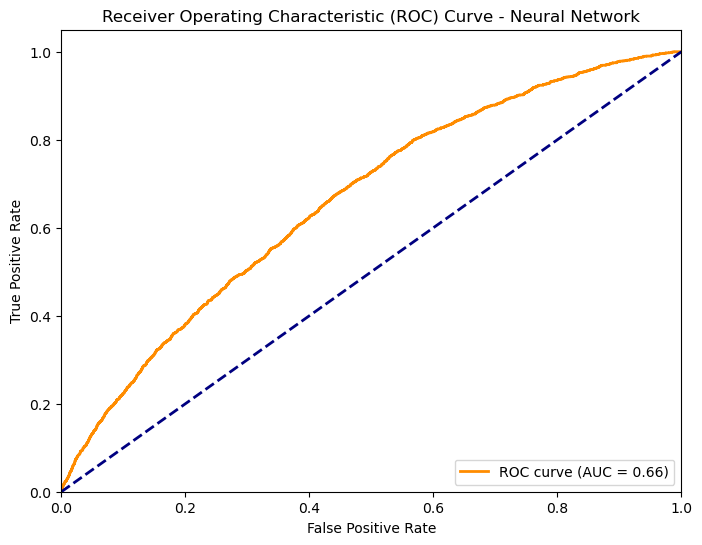

In [23]:
######################################################## print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))


fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()

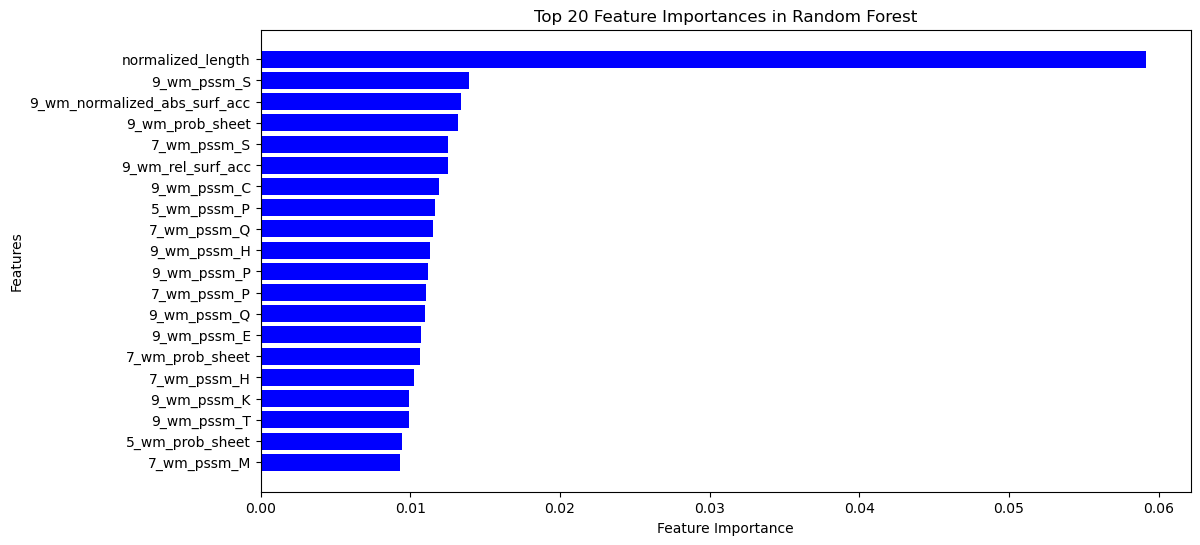

In [24]:
###################################################### feature importance analysise

#fix differetn formats
importances = best_rf.feature_importances_
# Ensure you have the correct feature names
train_df_test = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names_test = train_df_test.columns  # Ensure X_train is a DataFrame

# numpy to df
X_train_names = pd.DataFrame(X_train, columns=feature_names_test)


# Create DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_test,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='blue')
plt.gca().invert_yaxis()  # Invert y-axis so the most important feature is on top
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importances in Random Forest")
plt.show()


In [25]:
################################################################################ setup SHARP model
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

C:\Users\youpz\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(15545, 151))']
 

<Figure size 640x480 with 0 Axes>

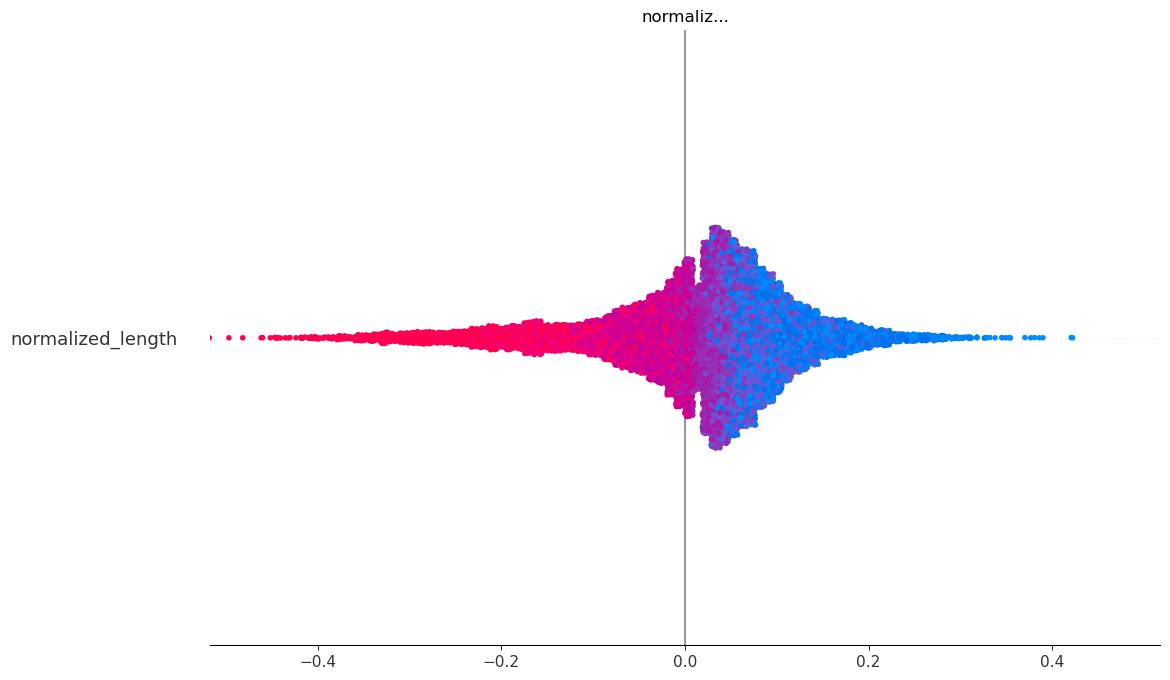

In [26]:
#################################### print feature importance and get the names feature

#global feature importance
test_df = test_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names_2 = test_df.columns  

# Convert numpy to df
X_test_names = pd.DataFrame(X_test, columns=feature_names_2)

# plot outcome --> red is 0 and blue is 1, x-as is the value of normalized length and line is 0
shap.summary_plot(shap_values, X_test_names)

In [27]:
def build_model(hp):
    """Build and compile a Keras model to get optimale hyperparamters"""
    model = Sequential()

    #  tune number of first layers
    units_input = hp.Int('units_input', min_value=128, max_value=512, step=128)
    model.add(Dense(units_input, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer  --> sigmoid for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # tune the learning rate
    lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    #compile model --> tested best method is binary_crossentropy --> looks for best AUC
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')]
    )
    return model

In [28]:
class MyHyperband(kt.Hyperband):
    """
    function that lets you also set some additional hyperparatmers
    """

    def run_trial(self, trial, x, y, **fit_kwargs):
        hp = trial.hyperparameters

        # define (batch_size) training-related hyperparameters here
        fit_kwargs['batch_size'] = hp.Choice('batch_size', [32, 64, 128])
    

        #build model with current paramters
        model = self.hypermodel.build(hp)

        #train model
        history = model.fit(x, y, **fit_kwargs)

        #track loss and AUC
        final_val_loss = history.history['val_loss'][-1]
        final_val_auc  = history.history['val_AUC'][-1]

        #update scores
        self.oracle.update_trial(
            trial.trial_id,
            {'val_loss': final_val_loss, 'val_AUC': final_val_auc}
        )

    
        # return loss and AUC
        return {'val_loss': final_val_loss, 'val_AUC': final_val_auc}

In [29]:
############################################## setting up and running the hyperparamter tuning

# usign MyHyperband to search for optimale hyperparameters
tuner = MyHyperband(
    build_model,
    objective=kt.Objective("val_AUC", direction="max"),
    max_epochs=20,   
    factor=3,
    overwrite=True,
    directory="my_dir",
    project_name="nn_tuning"
)

# compute early stopping to overcome overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Run the hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=20,                    # set variable
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[stop_early],
    verbose=1
)


Trial 30 Complete [00h 00m 17s]
val_AUC: 0.6302183270454407

Best val_AUC So Far: 0.665543258190155
Total elapsed time: 00h 09m 20s


In [30]:
########################################################### get paramters from hyper 
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
param_values = best_hps.values
print(param_values)

{'units_input': 128, 'learning_rate': 0.0001, 'batch_size': 32, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [31]:
#################################################### train model using optimal setting
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train, y_train,
    batch_size=best_hps.get('batch_size'),
    epochs=50,  # can be changed
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[stop_early] #prevent overfitting
)

Epoch 1/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.6168 - accuracy: 0.5771 - loss: 1.5464 - val_AUC: 0.6388 - val_accuracy: 0.1841 - val_loss: 1.7756
Epoch 2/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 2s 927us/step - AUC: 0.7245 - accuracy: 0.5859 - loss: 0.8213 - val_AUC: 0.6465 - val_accuracy: 0.1746 - val_loss: 2.0224
Epoch 3/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 2s 938us/step - AUC: 0.7644 - accuracy: 0.5939 - loss: 0.7557 - val_AUC: 0.6567 - val_accuracy: 0.1962 - val_loss: 1.9267
Epoch 4/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 2s 962us/step - AUC: 0.7871 - accuracy: 0.6049 - loss: 0.7231 - val_AUC: 0.6461 - val_accuracy: 0.2031 - val_loss: 1.9119


In [32]:
############################################################ get scores best NN
y_pred_probs_NN = best_model.predict(X_test).flatten()
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)

print("Accuracy:", accuracy_NN)
print("Precision:", precision_NN)
print("Recall:", recall_NN)
print("F1 Score:", f1_NN)


486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
Accuracy: 0.1993567063364426
Precision: 0.13150895856662934
Recall: 0.9806889352818372
F1 Score: 0.23191804492717846


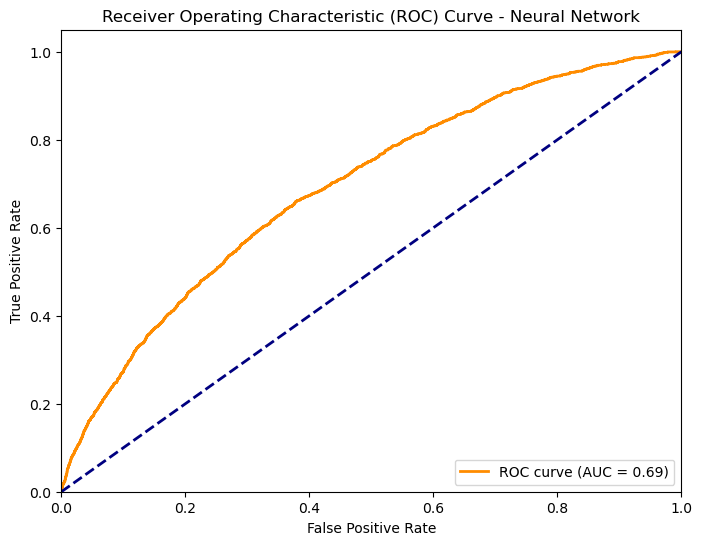

In [33]:
######################################################################## plot AUC-ROC best NN
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()

In [34]:
#############################################use shap for other model

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(best_model, background)

# Compute SHAP values for test data
shap_values_2 = explainer.shap_values(X_test)

C:\Users\youpz\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_352
Received: inputs=['Tensor(shape=(100, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_352
Received: inputs=['Tensor(shape=(200, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_352
Received: inputs=['Tensor(shape=(1554

<Figure size 640x480 with 0 Axes>

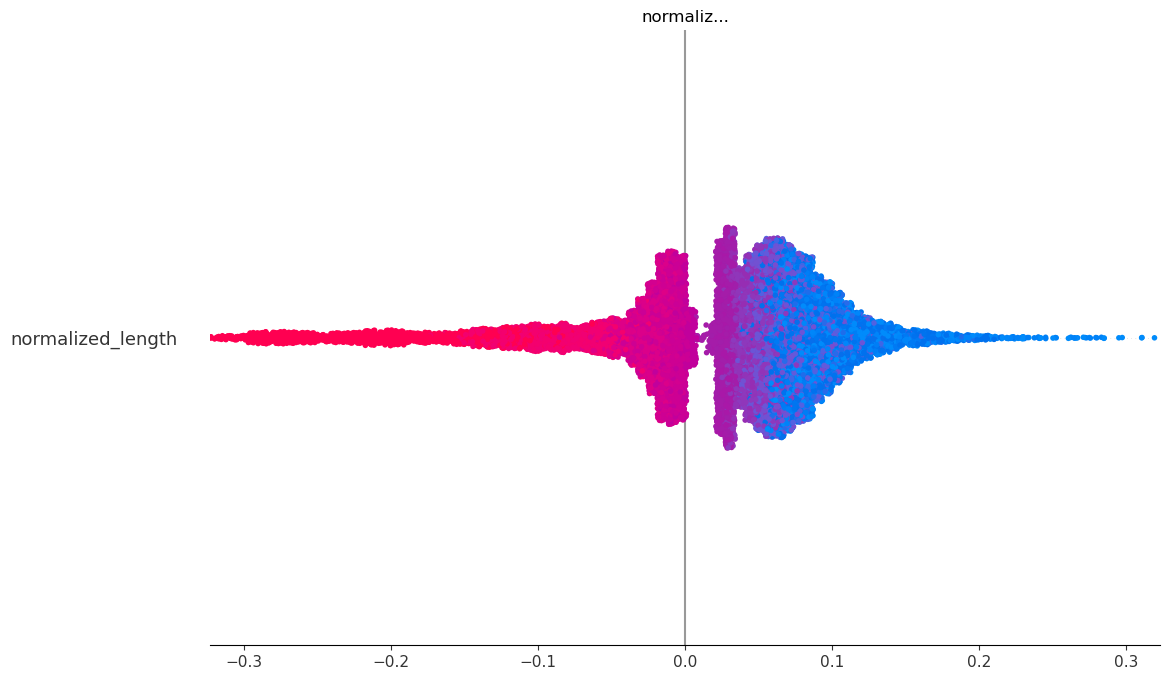

In [35]:
################################################ plot feature importancce of best NN
shap.summary_plot(shap_values_2, X_test_names)

In [36]:
################################################## getting normelized lenght
X_train_length = X_train[:, 0].reshape(-1, 1)  
X_test_length  = X_test[:, 0].reshape(-1, 1) 


In [37]:
################################################## running logistic regression with one variable
model_single = LogisticRegression()
model_single.fit(X_train_length, y_train)

LogisticRegression()

In [38]:
#################################################### getting reuslts logistic regression with one variable
y_pred_probs_LR_single = model_single.predict_proba(X_test_length)[:, 1]

# Convert to binary predictions using a threshold of 0.5
y_pred_class_LR_single = (y_pred_probs_LR_single >= 0.5).astype(int)

# Evaluate scores
accuracy_LR_single  = accuracy_score(y_test, y_pred_class_LR_single)
precision_LR_single = precision_score(y_test, y_pred_class_LR_single, zero_division=0)
recall_LR_single    = recall_score(y_test, y_pred_class_LR_single, zero_division=0)
f1_LR_single        = f1_score(y_test, y_pred_class_LR_single, zero_division=0)

#print scores
print("Accuracy (LR_single):", accuracy_LR_single)
print("Precision (LR_single):", precision_LR_single)
print("Recall (LR_single):", recall_LR_single)
print("F1 (LR_single):", f1_LR_single)

#print classification report
print(classification_report(y_test, y_pred_class_LR_single, zero_division=0))

Accuracy (LR_single): 0.5123190736571245
Precision (LR_single): 0.17067782815951635
Recall (LR_single): 0.7661795407098121
F1 (LR_single): 0.2791670628506228
              precision    recall  f1-score   support

           0       0.94      0.48      0.63     13629
           1       0.17      0.77      0.28      1916

    accuracy                           0.51     15545
   macro avg       0.55      0.62      0.46     15545
weighted avg       0.84      0.51      0.59     15545



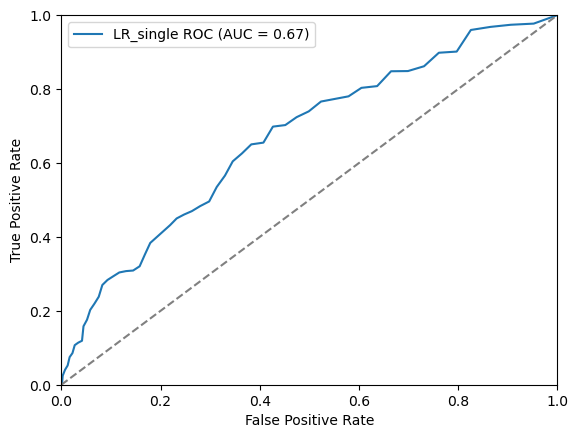

In [39]:
################################################## plotting roc results Linear regression using 
#compute AUC
fpr_LR_single, tpr_LR_single, thresholds_LR_single = roc_curve(y_test, y_pred_probs_LR_single)
roc_auc_LR_single = auc(fpr_LR_single, tpr_LR_single)

#plot ROC
plt.plot(fpr_LR_single, tpr_LR_single, label=f"LR_single ROC (AUC = {roc_auc_LR_single:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [40]:
################################################################################## permutation test using AUC frop
def permutation_importance_keras_auc(model, X, y, n_repeats=5, random_state=42):
    """
    model to see which features let the AUC drop most
    """
    #  Compute baseline AUC
    baseline_probs = model.predict(X).ravel()  # probabilities
    baseline_auc = roc_auc_score(y, baseline_probs)

    #random 
    rng = np.random.default_rng(random_state)
    importances = np.zeros(X.shape[1])

    # For each feature i shuffle it and measure AUC drop
    for i in range(X.shape[1]):
        score_decreases = []
        for _ in range(n_repeats):
            X_permuted = X.copy()  
            rng.shuffle(X_permuted[:, i])  
            perm_probs = model.predict(X_permuted).ravel()
            perm_auc = roc_auc_score(y, perm_probs)

            # how much dit the auc drop
            score_decreases.append(baseline_auc - perm_auc)

        # avarage drop feature in auc
        importances[i] = np.mean(score_decreases)
        
    #return outcome
    return importances, baseline_auc


In [41]:
########################################## running permutation test
importances, baseline_auc = permutation_importance_keras_auc(model, X_test, y_test)



486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
486/486 ━━━

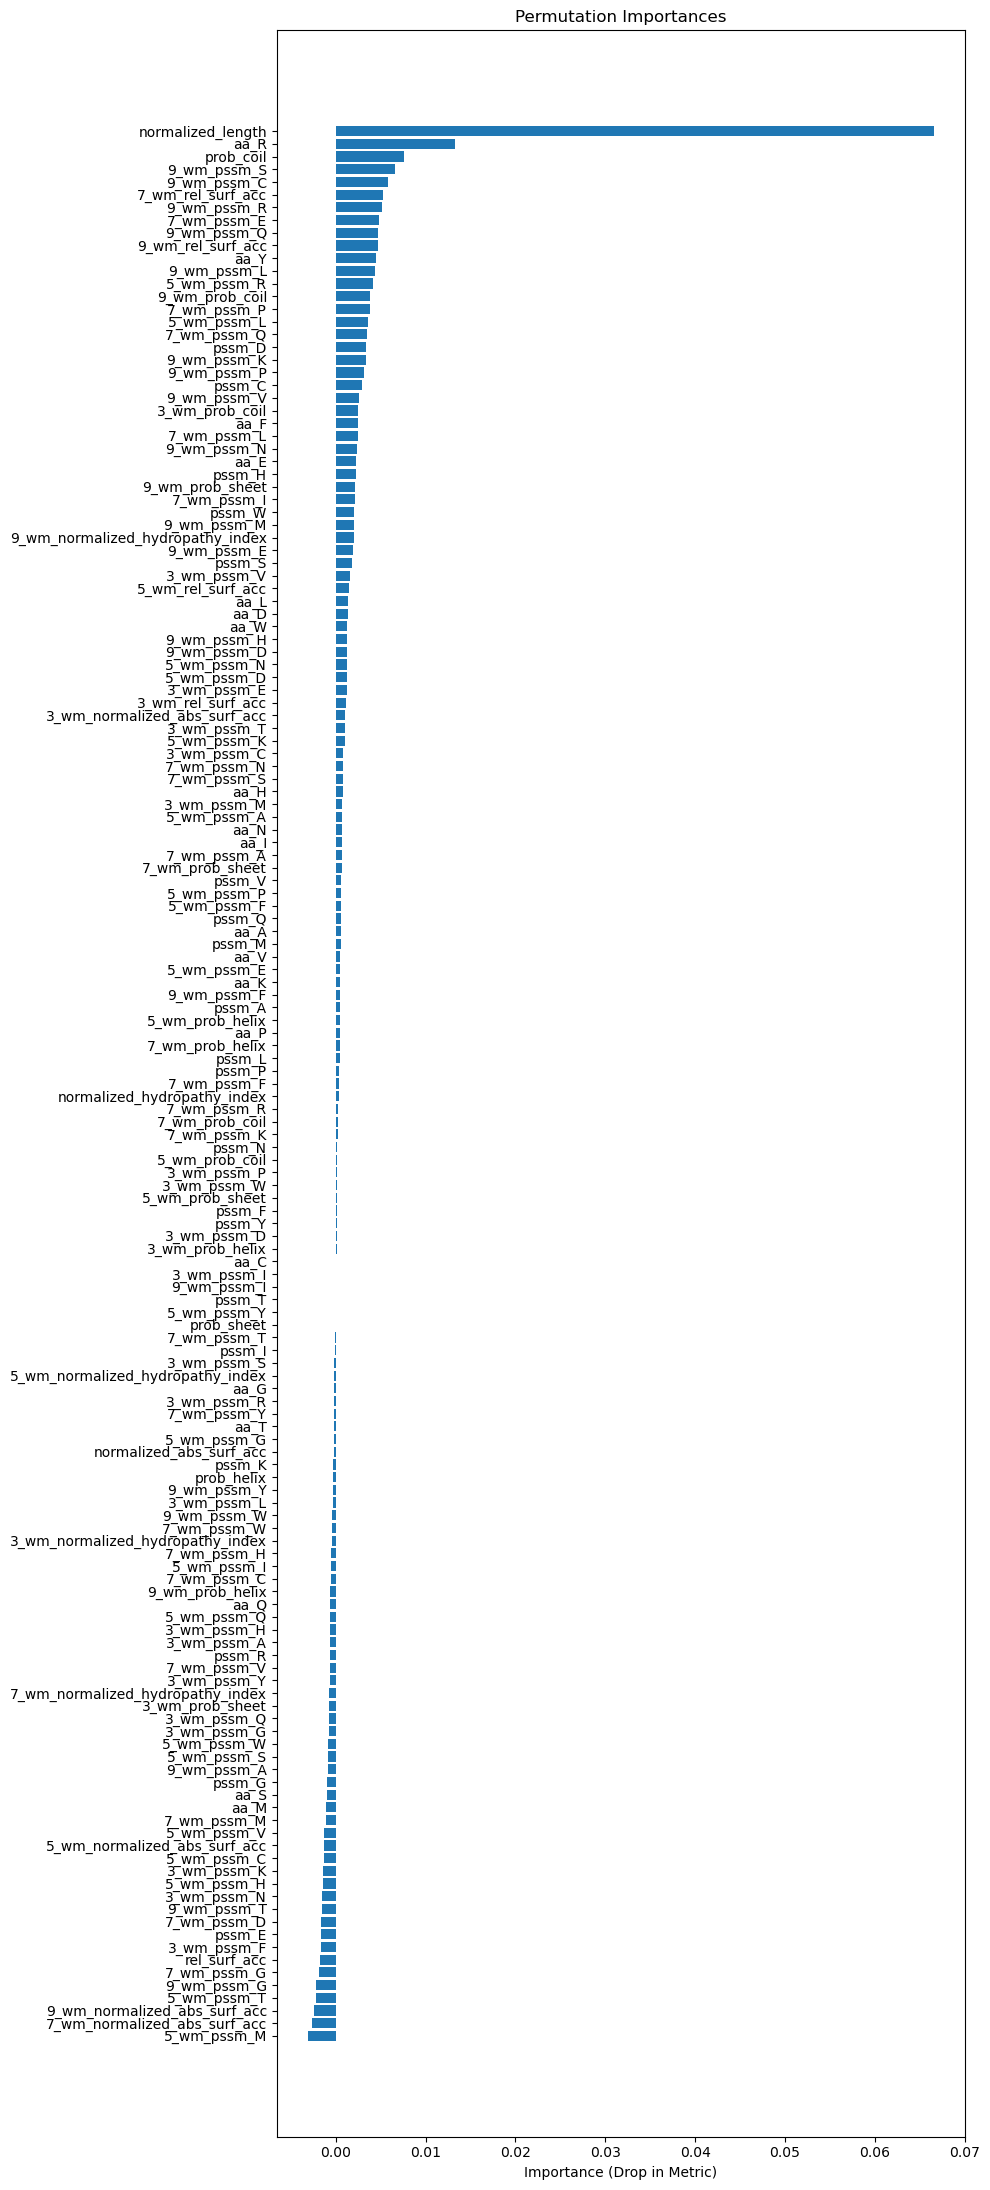

In [42]:
############################################################## sort importance and plot inmpact

def plot_permutation_importances(importances, feature_names, title="Permutation Importances"):
    indices = np.argsort(importances)[::-1]  # sort descending
    sorted_importances = importances[indices]
    sorted_features = [feature_names[i] for i in indices]

    # make iit horizonontal and big so you read the names
    plt.figure(figsize=(10, 22))
   
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_features)
    
    plt.gca().invert_yaxis()
    
    plt.xlabel("Importance (Drop in Metric)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_permutation_importances(importances, feature_names_test)